In [1]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
import datetime
from importlib import reload
from sklearn.pipeline import FeatureUnion
import TSManager as ts

# Split training and testing dataset

In [2]:
reload(ts)
mgr = ts.TSManager()
mgr.load()

Loading CAPE
Loading IC
Loading CPI
Loading VRP
Loading PCR
Loading SIM
Loading BY
Loading SI
Loading OIL
Loading BM
Loading PCAPrice
Loading CAY
Loading MA
Loading NOS
Loading TERM
Loading DP
Loading DEF
Loading SPX
Loading BDI
Loading PE
Loading RF


### Train date: 1990,06,08-2015,05,04

In [3]:
data=mgr.data
last_train_date=datetime.datetime(2015, 5, 4)
train=data[data.index<=last_train_date]
test=data[data.index>last_train_date]

In [4]:
train.head()

,CAPE,IC,CPI,VRP,PCR,SIM,BY,SI,OIL,BM,...,CAY,MA,NOS,TERM,DP,DEF,SPX,BDI,PE,RF
AsOfDate,,,,,,,,,,,,,,,,,,,,,
1990-06-08,8.978524,NaN,0.046737,7.197727,-1.622923,0.715385,1.007418,NaN,NaN,NaN,...,-0.013576,1,0.016941,0.50,0.063979,0.96,-0.012302,1278.0,7.524271,NaN
1990-06-11,9.051612,NaN,0.046737,5.607431,-1.615366,0.707692,1.009642,NaN,NaN,NaN,...,-0.013576,1,0.016941,0.49,0.063463,0.96,0.008107,1264.0,7.597792,NaN
1990-06-12,9.167251,NaN,0.046737,6.403252,-1.618868,0.700000,1.009580,NaN,NaN,NaN,...,-0.013576,1,0.016941,0.49,0.062662,0.96,0.012695,1254.0,7.699009,NaN
1990-06-13,9.133460,NaN,0.046737,7.793147,-1.625316,0.692308,1.000056,NaN,NaN,NaN,...,-0.013576,1,0.016941,0.47,0.062894,0.96,-0.003693,1243.0,7.674771,NaN
1990-06-14,9.083400,NaN,0.046737,7.665179,-1.620454,0.684615,0.997689,NaN,NaN,NaN,...,-0.013576,1,0.016941,0.46,0.063241,0.96,-0.005496,1232.0,7.636994,NaN


In [5]:
#future return
train.loc[:,'R_1M']=train['SPX'].index.map(
lambda x: (1+train.truncate(before=x + pd.Timedelta(1,unit='d'), after=x + pd.Timedelta(30,unit='d'))['SPX']).prod()-1)
train.loc[:,'R_3M']=train['SPX'].index.map(
lambda x: (1+train.truncate(before=x + pd.Timedelta(1,unit='d'), after=x + pd.Timedelta(91,unit='d'))['SPX']).prod()-1)
train.loc[:,'R_6M']=train['SPX'].index.map(
lambda x: (1+train.truncate(before=x + pd.Timedelta(1,unit='d'), after=x + pd.Timedelta(182,unit='d'))['SPX']).prod()-1)
train.loc[:,'R_12M']=train['SPX'].index.map(
lambda x: (1+train.truncate(before=x + pd.Timedelta(1,unit='d'), after=x + pd.Timedelta(365,unit='d'))['SPX']).prod()-1)

C:\Users\xjl05\AppData\Local\conda\conda\envs\python353\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\xjl05\AppData\Local\conda\conda\envs\python353\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [6]:
train.loc[last_train_date-pd.Timedelta(30,unit='d'):,'R_1M']=np.nan
train.loc[last_train_date-pd.Timedelta(91,unit='d'):,'R_3M']=np.nan
train.loc[last_train_date-pd.Timedelta(182,unit='d'):,'R_6M']=np.nan
train.loc[last_train_date-pd.Timedelta(365,unit='d'):,'R_12M']=np.nan

# Prepocess

IC: de-median

VRP: de-median, and do 5% winsorization (because there are some outliers in the data)

BDI: take log, and de-median

SI: take log

Other features remain the same.

In [7]:
#pipelines to select columns
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]
#de-median
class DeMedian(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        self.median=0
    def fit(self, X):
        self.median=X.median()
        return self  # nothing else to do
    def transform(self, X):
        return X-self.median
#take log
class Log(BaseEstimator, TransformerMixin):
    def __init__(self): 
        return
    def fit(self, X):
        return self
    def transform(self, X):
        return np.log(X)
#trimmed
class Trimmed(BaseEstimator, TransformerMixin):
    def __init__(self,tail=0.05): #by default, first and last 2.5% data are trimmmed 
        self.tail=tail
        return
    def fit(self, X):
        self.lower=X.quantile(self.tail/2).values[0]
        self.upper=X.quantile(1-self.tail/2).values[0]
        return self
    def transform(self, X):
        return X.clip(self.lower,self.upper)

#pipeline to compute future return
class Log(BaseEstimator, TransformerMixin):
    def __init__(self): 
        return
    def fit(self, X):
        return self
    def transform(self, X):
        return np.log(X)

In [8]:
feature_list=['DP','PE','BM','CAPE','PCAPrice','BY','DEF','TERM','CAY',
              'SIM',
              'VRP','IC',
              'BDI','NOS','CPI','PCR','MA',
              #'PCA-tech',
              'OIL','SI'] 
R_list=['R_1M','R_3M','R_6M','R_12M']

treat_list=['IC','VRP','BDI','SI']

other_list=[i for i in feature_list if i not in treat_list]
IC_pipeline = Pipeline([
        ('selector', DataFrameSelector(['IC'])),
        ('demedian', DeMedian()),
    ])
VRP_pipeline = Pipeline([
        ('selector', DataFrameSelector(['VRP'])),
        ('demedian', DeMedian()),
        ('trimmed', Trimmed()),
    ])

BDI_pipeline = Pipeline([
        ('selector', DataFrameSelector(['BDI'])),
        ('log', Log()),
        ('demedian', DeMedian()),
    ])
SI_pipeline = Pipeline([
        ('selector', DataFrameSelector(['SI'])),
        ('log', Log()),
    ])
other_pipeline=Pipeline([
    ('selector', DataFrameSelector(other_list)),
])
full_pipeline = FeatureUnion(transformer_list=[
        ("IC_pipline", IC_pipeline),
        ("VRP_pipeline", VRP_pipeline),
        ("BDI_pipeline", BDI_pipeline),
        ("SI_pipeline", SI_pipeline),
        ("other_pipeline", other_pipeline),
    ])

In [9]:
train_prepared=full_pipeline.fit_transform(train)

In [10]:
train_prepared

array([[        nan,  0.73708797, -0.1528084 , ..., -1.62292303,
         1.        ,         nan],
       [        nan, -0.85320834, -0.16382346, ..., -1.6153656 ,
         1.        ,         nan],
       [        nan, -0.0573871 , -0.17176631, ..., -1.61886771,
         1.        ,         nan],
       ...,
       [-4.3       , -0.64222115, -0.92404402, ..., -0.4574592 ,
         1.        , -0.52399892],
       [-6.98      , -2.57190703, -0.93083521, ..., -0.44264525,
         1.        , -0.52399892],
       [-5.21      , -2.33401527, -0.93083521, ..., -0.44017394,
         1.        , -0.52399892]])

In [14]:
#transform the test data
test_prepared=full_pipeline.transform(test)

In [28]:
#save files
df_train_prepared=pd.DataFrame(train_prepared,columns=treat_list+other_list,index=train.index)
df_train_prepared[['SPX','RF']]=train[['SPX','RF']]
df_train_prepared.to_pickle('train_prepared.pkl')
df_test_prepared=pd.DataFrame(test_prepared,columns=treat_list+other_list,index=test.index)
df_test_prepared[['SPX','RF']]=test[['SPX','RF']]
df_test_prepared.to_pickle('test_prepared.pkl')

# Tables

## Table1

In [30]:
df_prepared=pd.DataFrame(train_prepared,columns=treat_list+other_list,index=train.index)
df_prepared[R_list]=train[R_list]

In [31]:
summary=df_prepared.describe().T
summary.loc[:,'Skewness']=df_prepared.skew()
summary.loc[:,'Kurtosis']=df_prepared.kurt()
summary.loc[feature_list+R_list][['count','min','25%','mean','50%','75%','max','std','Skewness','Kurtosis']]

,count,min,25%,mean,50%,75%,max,std,Skewness,Kurtosis
DP,6275.0,0.016091,0.021619,0.030313,0.023294,0.036607,0.077506,0.013598,1.376078,0.807164
PE,6275.0,6.632500,13.329156,17.149349,15.274371,18.615715,75.827909,8.268075,3.939150,20.689034
BM,3858.0,0.190303,0.342486,0.382313,0.367829,0.446324,0.683908,0.081155,0.091054,0.219331
CAPE,6275.0,7.395374,14.564245,18.176844,18.992797,21.157242,30.218934,5.022590,-0.041247,-0.509246
PCAPrice,6275.0,-3.531514,-0.769562,0.225213,-0.478372,1.497023,4.402838,1.545274,0.823031,-0.244657
BY,6275.0,0.552394,0.914494,0.973717,0.973263,1.036844,1.393599,0.100592,-0.063666,1.270132
DEF,6275.0,0.550000,0.690000,0.954183,0.870000,1.060000,3.380000,0.410862,3.140201,12.986900
TERM,6272.0,-0.950000,0.910000,1.865515,2.000000,2.790000,3.870000,1.161928,-0.290813,-0.984421
CAY,6275.0,-0.052577,-0.009389,0.005230,0.004489,0.018684,0.091062,0.025816,0.601011,1.697840
SIM,6275.0,0.000000,0.230769,0.474998,0.476923,0.715385,0.930769,0.278247,-0.006585,-1.212598


There are 6280 days in the paper, while 7265 business days in our dataset. 

In our dataset, there are a large number of missing values in SI, IC, BM. Because in our data, SI starts from 2013-05-10. IC starts from 2007-01-03. BM starts from 2999-12-31.

Other differences include:

(1) PE has significantly large skewness and kurtosis compared with the paper.

(2) CAPE has significantly small skewness and kurtosis compared with the paper.

(3) BY in our data are all positive, but at least half of the values are negative in the paper. BY has larger kurtosis in our dataset.

(4) VRP has smaller skewness and kurtosis compared with the paper, because we winsorize the data here.

(5) IC has higher skewness and lower kurtosis compared with the paper.

(6) BDI has higher skewness and smaller kurtosis compared with the paper.

(7) OIL hsa lower kutrtosis compared with the paper.

## Table2

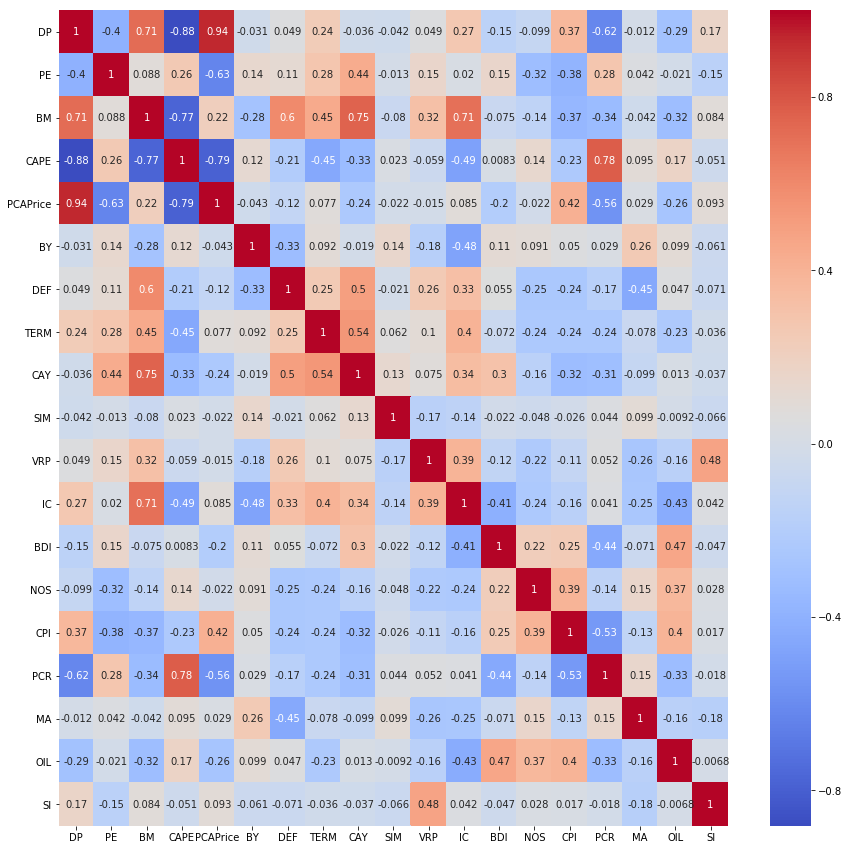

In [124]:
dfcorr=df_prepared[feature_list].corr()
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
ax = sns.heatmap(dfcorr, annot=True,cmap='coolwarm')

Some major differences:

(1) Correlation between BM and PE are weak in our dataset, but it is significantly negative in the paper.

(2) PCA price's correlations with DP, PE, BM, CAPE and PCR are against the paper.

(3) CAY's correlations with BM, CAPE, DEF, TERM are stronger than in the paper.

(4) IC's correlations with BM, CAPE, BY are stronger than in the paper.

### Table 3

In [118]:
df_prepared.corr().loc[feature_list,R_list]

,R_1M,R_3M,R_6M,R_12M
DP,0.063838,0.133013,0.224262,0.293655
PE,-0.027207,-0.048523,-0.103690,-0.088198
BM,0.163360,0.256293,0.400580,0.549985
CAPE,-0.082864,-0.152993,-0.253578,-0.376509
PCAPrice,0.073486,0.146037,0.237166,0.308255
BY,-0.037205,-0.027679,-0.029067,0.034673
DEF,-0.068084,-0.101034,-0.047819,0.005723
TERM,-0.032773,-0.058179,-0.042261,0.063560
CAY,0.031367,0.050368,0.073176,0.156679
SIM,-0.027564,-0.114649,-0.144264,-0.006873


Major differences:

(1) PCAPrice's correlations with returns are positive in our data, but negative in the paper.

(2) IC's correlations with returns are stronger than in the paper, and it's correlation with R_12M is positive.

(3) BDI's correlations with returns are positive in our data, but negative in the paepr.

(4) OIL's correlations with returns are more negative compared with the paper.

(5) SI's correlations with returns are positive in our data, but negative in the paper.